In [316]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers import LSTM, Bidirectional
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers import TimeDistributed, Activation, MaxPooling1D, Embedding
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque

In [1]:
class CONFIG:
    TRAIN_DATA_PATH = '../capture/TRAIN_TEST/train/train.csv'
    TEST_DATA_PATH = '../capture/TRAIN_TEST/val/test.csv'

In [4]:
#Define train test
df_train = pd.read_csv(CONFIG.TRAIN_DATA_PATH)
df_test = pd.read_csv(CONFIG.TEST_DATA_PATH)

In [6]:
df_train.head()

,label,pixels_1,pixels_2,pixels_3,pixels_4,pixels_5,pixels_6,pixels_7,pixels_8,pixels_9,...,pixels_4087,pixels_4088,pixels_4089,pixels_4090,pixels_4091,pixels_4092,pixels_4093,pixels_4094,pixels_4095,pixels_4096
0,0,135,136,137,141,147,166,171,170,170,...,80,57,52,53,61,71,65,91,109,119
1,0,218,217,218,213,218,220,218,221,224,...,20,23,26,26,23,23,24,25,22,27
2,0,237,237,242,242,237,237,238,245,245,...,31,24,21,26,30,27,26,28,31,27
3,0,235,236,234,236,241,240,240,244,245,...,22,27,32,28,20,17,21,23,25,28
4,0,224,224,224,224,223,224,225,225,224,...,102,107,115,129,141,149,153,151,155,184


In [7]:
#preprocess
y_train = df_train['label']
y_test = df_test['label']

In [8]:
x_train = df_train.drop(columns=['label'], axis=1)
x_test = df_test.drop(columns=['label'], axis=1)

In [9]:
x_train = x_train.values
x_test = x_test.values

In [10]:
#normalize
x_train = x_train/255
x_test = x_test/255

In [11]:
x_train.shape

(139, 4096)

In [12]:
#reshape to 3D
x_train = x_train.reshape(-1, 64, 64, 1)
x_test = x_test.reshape(-1, 64, 64, 1)

In [27]:
print(x_train.shape)
print(x_test.shape)

(139, 64, 64, 1)
(36, 64, 64, 1)


In [230]:
#augmentation
datagenerator = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,    # randomly flip images
)  


datagenerator.fit(x_train)

In [277]:
#CNN
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

#compile model
optimizer = Adam(lr=0.0002)
cnn.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#summary
cnn.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_403 (Conv2D)         (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_306 (MaxPooli  (None, 31, 31, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_404 (Conv2D)         (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_307 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_405 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_308 (MaxPooli  (None, 6, 6, 64)       

In [278]:
#fit model
history=cnn.fit(datagenerator.flow(x_train, y_train,batch_size=5,shuffle=True),
                  epochs=150,
                #   class_weight=class_weight, #Jika imbalance, untuk balancing data
                  # callbacks=[learning_rate_reduction],
                  validation_data=(x_test, y_test)) 

Epoch 1/150
28/28 [==============================] - 2s 38ms/step - loss: 0.6952 - accuracy: 0.5180 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/150
28/28 [==============================] - 1s 17ms/step - loss: 0.6946 - accuracy: 0.4317 - val_loss: 0.6931 - val_accuracy: 0.5556
Epoch 3/150
28/28 [==============================] - 0s 17ms/step - loss: 0.6930 - accuracy: 0.5468 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/150
28/28 [==============================] - 1s 18ms/step - loss: 0.6945 - accuracy: 0.5108 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 5/150
28/28 [==============================] - 0s 17ms/step - loss: 0.6927 - accuracy: 0.5108 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 6/150
28/28 [==============================] - 0s 17ms/step - loss: 0.6939 - accuracy: 0.5108 - val_loss: 0.6916 - val_accuracy: 0.6111
Epoch 7/150
28/28 [==============================] - 0s 17ms/step - loss: 0.6926 - accuracy: 0.5540 - val_loss: 0.6921 - val_accuracy: 0.5833
Epoch 

<AxesSubplot:>

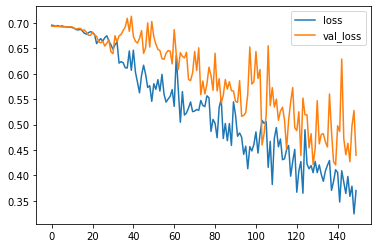

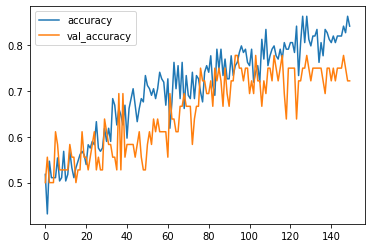

In [279]:
losses = pd.DataFrame(cnn.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

In [280]:
#Model Evaluation
y_pred = cnn.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

2/2 [==============================] - 0s 7ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        18
           1       0.00      0.00      0.00        18

    accuracy                           0.50        36
   macro avg       0.25      0.50      0.33        36
weighted avg       0.25      0.50      0.33        36



c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [291]:
# #cnn-lstm

# model = Sequential()
# #cnn
# model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', input_shape=(64, 64, 1))))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# # layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
# # layers.MaxPooling2D((2, 2)),

# # layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
# # layers.MaxPooling2D((2, 2)),
    
# model.add(TimeDistributed(Flatten()))

# #lstm
# model.add(LSTM(64, dropout=0.05, recurrent_dropout=0.20))
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(10, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['acc'])

# #model.summary()

c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [297]:
# #cnn-lstm

# cnn = Sequential()
# #cnn
# cnn.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', input_shape=(64, 64, 1))))
# cnn.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# # layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
# # layers.MaxPooling2D((2, 2)),

# # layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
# # layers.MaxPooling2D((2, 2)),
    
# model.add(TimeDistributed(Flatten()))

# #lstm
# model.add(LSTM(64, dropout=0.05, recurrent_dropout=0.20))
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(10, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['acc'])

# #model.summary()

c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# history=model.fit(x_train, y_train, 
#                   batch_size=3, 
#                   epochs=30,
#                 #   class_weight=class_weight, #Jika imbalance, untuk balancing data
#                   # callbacks=[weight_saver, annealer],
#                   validation_data=(x_test, y_test)) 

In [317]:
# model = Sequential()
# model.add(Embedding(20000, 128, input_length=100))
# model.add(Dropout(0.25))
# model.add(Conv1D(32,
#                  3,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(32))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.summary()

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 dropout_38 (Dropout)        (None, 100, 128)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 98, 32)            12320     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 49, 32)           0         
 1D)                                                             
                                                                 
 lstm_22 (LSTM)              (None, 32)                8320      
                                                                 
 dense_192 (Dense)           (None, 1)                 33        
                                                    

In [ ]:
# history = model.fit(datagenerator.flow(x_train, y_train, batch_size=5),
#             epochs=30,
#             validation_data=(x_test, y_test),
#             shuffle = True)

In [ ]:
# model = Sequential()
# model.add(Conv1D(filters=32, kernel_size=(3), activation='sigmoid', input_shape=(64,64,1)))
# model.add(MaxPooling1D(pool_size=4))
# model.add(LSTM(32))
# model.add(Dense(32, activation='sigmoid'))
# model.add(Dense(16, activation='relu'))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()